In [16]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse 
import sys
from gaussiandata import SyntheticTarget
import math
import scipy

import matplotlib.pyplot as matlab
%matplotlib inline

In [17]:
SEED = 666
number_of_gaussians = 2
ex = SyntheticTarget(seed=SEED, dist_components=number_of_gaussians)

N = 10000
M = 100
data = ex.draw_sample(N)
gamma = 2
kernel_matrix = rbf_kernel(data, gamma = gamma)

In [18]:
# K is the kernel matrix which is nbyn, n being the number of data points
# candidate indicies is an array of 0 to n-1, you might want to use a subset instead. TO CONSIDER.

def greedy_select_protos(K, candidate_indices, m, is_K_sparse=False):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    # colsum = np.array(K.sum(0)).ravel() # same as rowsum
    if is_K_sparse:
        colsum = 2*np.array(K.sum(0)).ravel() / n
    else:
        colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
    value = np.array([])
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        if len(selected) > 0:
            temp = K[selected, :][:, candidates]
            if is_K_sparse:
                # s2array = temp.sum(0) *2
                s2array = temp.sum(0) * 2 + K.diagonal()[candidates]

            else:
                s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]

            s2array = s2array/(len(selected) + 1)

            s1array = s1array - s2array

        else:
            if is_K_sparse:
                s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
            else:
                s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))

        argmax = candidates[np.argmax(s1array)]
        # print "max %f" %np.max(s1array)

        selected = np.append(selected, argmax)
        # value = np.append(value,maxx)
        KK = K[selected, :][:, selected]
        if is_K_sparse:
            KK = KK.todense()

        inverse_of_prev_selected = np.linalg.inv(KK)  # shortcut

    return candidate_indices[selected]

In [19]:
#print np.array(range(np.shape(kernel_matrix)[0]))
#print np.array(range(N))
prototype_indices = greedy_select_protos(kernel_matrix, candidate_indices = np.array(range(N)), m = M)

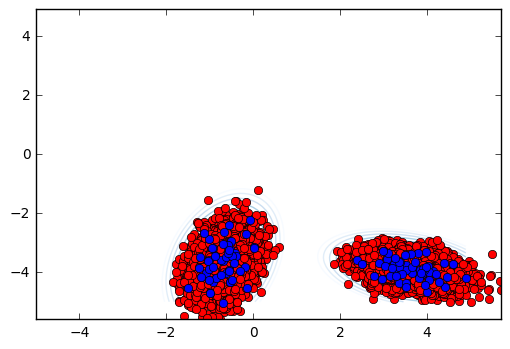

In [20]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');

In [21]:
##############################################################################################################################
# function to select criticisms
# K is the kernel matrix which is nbyn, n being the number of data points
# selectedprotos: prototypes already selected
# m : number of criticisms to be selected
# reg: regularizer type.
# is_K_sparse:  True means K is the pre-computed  csc sparse matrix? False means it is a dense matrix.
# RETURNS: indices selected as criticisms
##############################################################################################################################
def greedy_select_criticism_regularized(K, selectedprotos, m, reg='logdet', is_K_sparse=False):

    n = np.shape(K)[0]
    if reg in ['None','logdet','iterative']:
        pass
    else:
        print "wrong regularizer :" + regularizer
        exit(1)
    options = dict()

    selected = np.array([], dtype=int)
    candidates2 = np.setdiff1d(range(n), selectedprotos)
    inverse_of_prev_selected = None  # should be a matrix

    if is_K_sparse:
        colsum = np.array(K.sum(0)).ravel()/n
    else:
        colsum = np.sum(K, axis=0)/n

    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(candidates2, selected)

        s1array = colsum[candidates]

        temp = K[selectedprotos, :][:, candidates]
        if is_K_sparse:
            s2array = temp.sum(0)
        else:
            s2array = np.sum(temp, axis=0)

        s2array = s2array / (len(selectedprotos))

        s1array = np.abs(s1array - s2array)
        if reg == 'logdet':
            if inverse_of_prev_selected is not None: # first call has been made already
                temp = K[selected, :][:, candidates]
                if is_K_sparse:
                    temp2 = temp.transpose().dot(inverse_of_prev_selected)
                    regularizer = temp.transpose().multiply(temp2)
                    regcolsum = regularizer.sum(1).ravel()# np.sum(regularizer, axis=0)
                    regularizer = np.abs(K.diagonal()[candidates] - regcolsum)

                else:
                    # hadamard product
                    temp2 = np.array(np.dot(inverse_of_prev_selected, temp))
                    regularizer = temp2 * temp
                    regcolsum = np.sum(regularizer, axis=0)
                    regularizer = np.log(np.abs(np.diagonal(K)[candidates] - regcolsum))
                s1array = s1array + regularizer
            else:
                if is_K_sparse:
                    s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
                else:
                    s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))
        argmax = candidates[np.argmax(s1array)]
        maxx = np.max(s1array)

        selected = np.append(selected, argmax)
        if reg == 'logdet':
            KK = K[selected,:][:,selected]
            if is_K_sparse:
                KK = KK.todense()

            inverse_of_prev_selected = np.linalg.inv(KK) # shortcut
        if reg == 'iterative':
            selectedprotos = np.append(selectedprotos, argmax)

    return selected


In [28]:
#included argument is_K_sparse = False since otherwise todense function is not recognized. CHECK.
criticism_indices = greedy_select_criticism_regularized(kernel_matrix, selectedprotos = prototype_indices, m = M/5,  is_K_sparse=False)

#K_sparse = sparse.csr_matrix(kernel_matrix)
#criticism_indices = greedy_select_criticism_regularized(kernel_matrix, selectedprotos = prototype_indices, m = M/4,  is_K_sparse=True)

In [29]:
#print criticism_indices

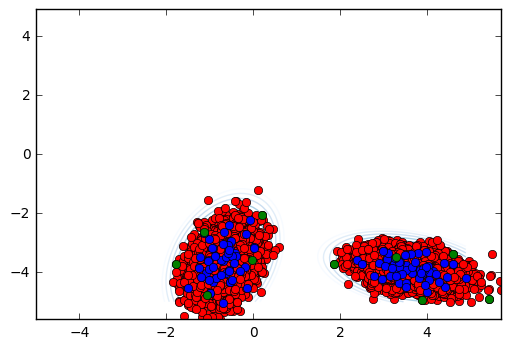

In [30]:
ex.plot()
matlab.plot(data[:N,0], data[:N,1], 'ro');
matlab.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
matlab.plot(data[criticism_indices,0], data[criticism_indices,1], 'go');